<a href="https://colab.research.google.com/github/maxmrv/maxmrv/blob/main/WATV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 34.9 MB/s eta 0:00:00


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pywt.data
import seaborn as sns

Show all wavelet families

In [3]:
print(pywt.families())

['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor']


In [8]:
def add_noise(inp: np.array, sigma: float) -> np.array:
  x = np.random.normal(0, sigma, inp.shape)
  return inp + x

In [9]:
def calc_rmse(inp: np.array, out: np.array) -> float:
  return np.sqrt(np.mean((inp - out) ** 2))

In [10]:
def diff_matrix(d_size: int) -> np.array:
  ret = np.identity(d_size) * -1
  for i in np.arange(1, d_size):
    ret[i, i - 1] = 1
  return ret

In [11]:
def calc_tv(inp: np.array) -> float:
  d_matrix = diff_matrix(inp.shape[0])
  return np.sum(np.abs(np.matmul(d_matrix, inp)))

Implement the penalty function as given in the article:
\begin{equation}
𝜙(x;a) =
\begin{cases}
\frac{2}{a\sqrt{3}} (atan(\frac{1+2a|x|}{\sqrt{3}})-\frac{π}{6}), & a>0 \\
|x|, & a=0
\end{cases}
\end{equation}

In [64]:
def calc_phi(x: np.array, a: float) -> np.array:
  if a > 0:
    return 2 / (a * np.sqrt(3)) * (np.arctan((1 + 2 * a * np.abs(x)) / np.sqrt(3)) - np.pi / 6)
  else:
    return np.abs(x)

Implement the gradient of 𝜙

In [67]:
def calc_grad_phi(x: np.array, a: float) -> np.array:
  if a > 0:
    return x / ((a ** 2) * (np.abs(x) ** 3) + a * x ** 2 + np.abs(x))
  else:
    return np.sign(x)

Generic Proximal Mapping

In [75]:
from collections.abc import Callable
def prox_mapping(grad_f: Callable, x: float, lambda_param: float, a: float, max_iter=100, tol=1e-6):
    y = x
    for _ in range(max_iter):
        grad = grad_f(y, a)  # Compute the gradient of f at y
        step = grad + (y - x) / lambda_param  # Combined gradient term
        y_new = y - lambda_param * step  # Update y using the gradient
        if abs(y-y_new) < tol:  # Convergence check
            break
        y = y_new
    return y_new

Plot some penalty functions for different values of a

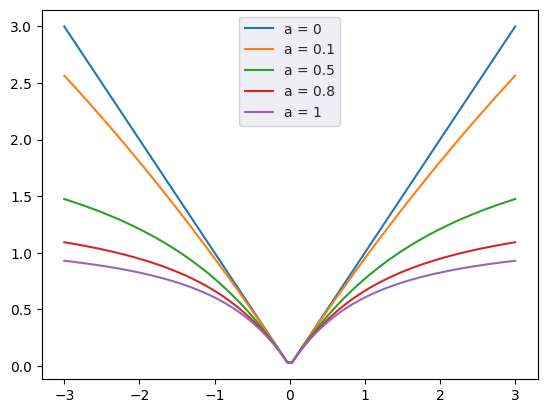

In [65]:
a = [0, 0.1, 0.5, 0.8, 1]
x = np.linspace(-3, 3, 100)
for i in a:
  sns.lineplot(x=x, y=calc_phi(x, i), label=f"a = {i}")
sns.set_style("darkgrid")
sns.set_palette("bright")
plt.legend()
plt.show()


**Auxiliary algorithm - 1D TV Denoising**

In [48]:
def tvd(y: np.array, lmbda: float) -> np.array:
  x = np.zeros_like(y)
  k: int = 0
  k0: int = 0
  k_minus: int = 0
  k_plus: int = 0
  N: int = y.shape[0]
  v_min: float = y[0] - lmbda
  v_max: float = y[0] + lmbda
  u_min: float = lmbda
  u_max: float = -lmbda
  while True:
    # Step 2
    if k == N - 1:
      x[N-1] = v_min + u_min
      return x
    while k < N - 1:
      # Step 3
      if y[k+1] < v_min - lmbda - u_min:
        if k0 == k_minus:
          x[k0] = v_min
        elif k0 > k_minus:
          x[k_minus:k0] = v_min
        else:
          x[k0:k_minus] = v_min
        k = k_minus + 1
        k0 = k
        k_minus = k
        k_plus = k
        v_min = y[k]
        v_max = y[k] + 2 * lmbda
        u_min = lmbda
        u_max = lmbda * -1
      # Step 4
      elif y[k+1] > v_max + lmbda - u_max:
        if k0 == k_plus:
          x[k0] = v_max
        elif k0 > k_plus:
          x[k_plus:k0] = v_max
        else:
          x[k0:k_plus] = v_max
        k = k_plus + 1
        k0 = k
        k_plus = k
        k_minus = k
        v_min = y[k] - 2 * lmbda
        v_max = y[k]
        u_min = lmbda
        u_max = lmbda * -1
      # Step 5
      else:
        k = k + 1
        u_min = u_min + y[k] - v_min
        u_max = u_max + y[k] - v_max
        if u_min >= lmbda:
          v_min = v_min + (u_min - lmbda) / (k - k0 + 1)
          u_min = lmbda
          k_minus = k
        if u_max <= -lmbda:
          v_max = v_max + (u_max + lmbda) / (k - k0 + 1)
          u_max = -lmbda
          k_plus = k
      # Step 8
    if u_min < 0:
      if k0 == k_minus:
        x[k0] = v_min
      elif k0 > k_minus:
        x[k_minus:k0] = v_min
      else:
        x[k0:k_minus] = v_min
      k = k_minus + 1
      k0 = k
      k_minus = k
      v_min = y[k]
      u_min = lmbda
      u_max = y[k] + lmbda - v_max
    # Step 9
    elif u_max > 0:
      if k0 == k_plus:
        x[k0] = v_max
      elif k0 > k_plus:
        x[k_plus:k0] = v_max
      else:
        x[k0:k_plus] = v_max
      k = k_plus + 1
      k0 = k
      k_plus = k
      v_max = y[k]
      u_max = -lmbda
      u_min = y[k] - lmbda - v_min
    else:
      if k0 == N-1:
        x[k0] = v_min + u_min / (k - k0 + 1)
      else:
        x[k0:N] = v_min + u_min / (k - k0 + 1)
      return x
    return x


**Set up parameters**

*   η is the relative weight of wavelet and TV regularization
*   σ is the noise variance
*   μ is an arbitrary convergence parameter



In [6]:
eta = 0.95
sigma = 0.1
mu = 1

In [50]:
x = pywt.data.demo_signal('Gabor')
x = x / np.max(x)
x = np.real(x)
x_noised = add_noise(x, sigma)

In [24]:
x[80:90] = -1

<Axes: >

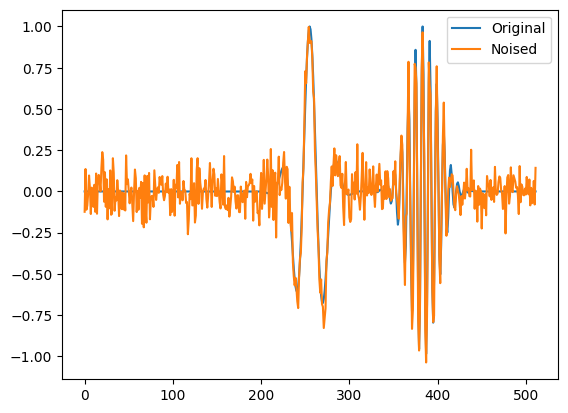

In [51]:
sns.lineplot(x=np.arange(x.shape[0]), y=x, label="Original")
sns.lineplot(x=np.arange(x_noised.shape[0]), y=x_noised, label="Noised")

<Axes: >

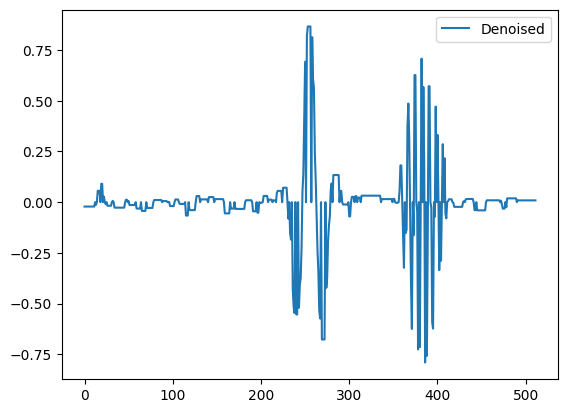

In [63]:
sns.lineplot(x=np.arange(x.shape[0]), y=tvd(x_noised, 0.15), label="Denoised")


In [80]:
print(prox_mapping(calc_grad_phi, -5.2, 2, 1))

-5.138543182747667
